# Vision Transformer

原論文  
https://openreview.net/forum?id=YicbFdNTTy

## アルゴリズムの理解

ViT は大きく以下の 3 つの部分で構成されている（画像クラス分類の場合）

- Input Layer
    - 入力（画像）をパッチに分割
    - 「クラストークン」 と 「パッチ」 のベクトルを出力
- Encoder
    - Self-Attention 処理
    - 「クラストークン」 を出力
- MLPHead
    - 入力画像に対するラベルを予測（クラス分類器）

![vit_01](image/vit_01.png)

### Input Layer

1. パッチに分割
2. 埋め込み (Embedding)
3. CLS (Class Token)
4. 位置埋め込み (Positional Embedding)

説明のため パッチ 4 つ で図解

- パッチに分割

![vit_patch](image/vit_patch.png)

- 埋め込み

![vit_patch2emb](image/vit_patch2emb.png)

- クラストークンと位置埋め込み

![vit_patch2clsemb](image/vit_patch2clsemb.png)

- 実装

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class VitInputLayer(nn.Module):
    def __init__(self,
        in_channels:int=3,
        emb_dim:int=384,
        nump_patch_row:int=2,
        image_size:int=32):

        super(VitInputLayer, self).__init__()
        self.in_channels = in_channels
        self.emb_dim = emb_dim
        self.num_patch_row = nump_patch_row
        self.image_size = image_size

        # パッチ数
        self.num_patch = self.num_patch_row**2
        # パッチのサイズ : 画像 1 辺が 32 なら patch_size = 16
        self.patch_size = int(self.image_size // self.num_patch_row)

        # 入力画像のパッチ分割・埋め込み
        self.patch_emb_layer = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.emb_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size)

        # CLS
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

        # Position Embedding
        # CLS が先頭に結合されているため長さ emb_dim の位置埋め込みベクトルを（パッチ数 +1）個用意
        self.pos_emb = nn.Parameter(torch.randn(1, self.num_patch+1, emb_dim))

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # パッチの埋め込み & flatten

        ## Patch の埋め込み (B, C, H, W) -> (B, D, H/P, W/P)
        z_0 = self.patch_emb_layer(x)

        ## パッチの flatten (B, D, H/P, W/P) -> (B, D, Np)
        ## Np はパッチの数 (=H*W/P^2)
        z_0 = z_0.flatten(2)

        ## 軸の入れ替え
        z_0 = z_0.transpose(1, 2)

        # パッチの埋め込みの先頭に CLS を結合
        ## (B, Np, D) -> (B, N, D) : N = (Np + 1)
        ## cls_token は (1, 1, D) なので repeat で (B, 1, D) に変換（複製）して結合する
        z_0 = torch.cat([self.cls_token.repeat(repeats=(x.size(0), 1, 1)), z_0], dim=1)

        # Position Embedding の加算
        ## (B, N, D) -> (B, N, D)
        z_0 = z_0 + self.pos_emb

        return z_0

In [4]:
# check
x = torch.randn(1, 3, 32, 32)
input_layer = VitInputLayer()
z_0 = input_layer(x)
z_0.shape

torch.Size([1, 5, 384])

### Encoder
#### Self-Attention（自己注意）
1. パッチ内の情報の抽出
    - -> 埋め込み
2. 自分との類似度測定
    - -> ベクトル同士の内積
3. 類似度に基づいた合体
    - -> 内積の値を係数にした加重和
    - -> 係数 : 内積の Softmax で算出
    - -> 加重和 : Attention Weight

Self-Attention のイメージ

![vit_self_attention_image](image/vit_self_attention_image.png)

Self-Attention でも、埋め込みによって情報の抽出を行う。  
線形層を 3 つ用意し、それぞれの線形層で埋め込んだあとの各ベクトルを以下のように呼ぶ。

- q (query)
- k (key)
- v (value)

q, k, v ともに全く同じベクトルから埋め込んだ結果だが、それぞれ異なる線形層を用いて埋め込まれているため、異なる値を取る。  

q, k, v に分ける表現は動画サイトの動画検索に例えるとわかりやすい。

- q : 検索キーワード
- k : 動画タイトル
- v : 動画

検索キーワードから動画を検索する際は、検索キーワードと動画のタイトルの一致度を見る。  
Self-Attention も同様に、q, k の類似度を計算し、その類似度をもとに v の加重和を行う。

内積 -> 行列積 (ソフトマックスで正規化) -> 類似度になる。

![vit_self_attention](image/vit_self_attention.png)

### Multi-Head Self-Attention
パッチ同士の関係は 1 つの Attension Weight が保持している。  
この Attention Weight が複数あれば、各パッチ間の関係を、Attention Weight の数だけ学習できる。  
1 つのパッチから複数個の q, k, v を埋め込み、複数の Attention Weight を獲得すれば良い。  
ハイパーパラメータ「ヘッドの数」で指定する。

In [5]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self,
        emb_dim:int=384,
        head:int=3,
        dropout:float=0.):

        super(MultiHeadSelfAttention, self).__init__()
        self.head = head
        self.emb_dim = emb_dim
        self.head_dim = emb_dim // head
        # D_h の 二乗根：qk^T を割るための係数
        self.sqrt_dh = self.head**0.5

        # 入力を query, key, value に埋め込むための線形層
        self.w_q = nn.Linear(emb_dim, emb_dim, bias=False)
        self.w_k = nn.Linear(emb_dim, emb_dim, bias=False)
        self.w_v = nn.Linear(emb_dim, emb_dim, bias=False)

        # Dropout
        self.attn_drop = nn.Dropout(dropout)

        # MHSA の結果を出力に埋め込むための線形層
        self.w_o = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.Dropout(dropout))

    def forward(self, z:torch.Tensor) -> torch.Tensor:
        batch_size, num_patch, _ = z.size()

        # 埋め込み:(B, N, D) -> (B, N, D)
        q = self.w_q(z)
        k = self.w_k(z)
        v = self.w_v(z)

        # (q, k, v) を head に分ける
        ## まずベクトルを head の個数に分ける
        ## (B, N, D) -> (B, N, h, D//h)
        q = q.view(batch_size, num_patch, self.head, self.head_dim)
        k = k.view(batch_size, num_patch, self.head, self.head_dim)
        v = v.view(batch_size, num_patch, self.head, self.head_dim)
        ## Self-Attention ができるように（バッチサイズ、ヘッド、トークン数、バッチのベクトル）の形状にする
        ## (B, N, h, D//h) -> (B, h, N, D///h)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # 内積
        ## (B, h, N, D//h) -> (B, h, D//h, N)
        k_T = k.transpose(2, 3)
        ## (B, h, N, D//h) x (B, h, D//h, N) -> (B, h, N, N)
        dots = (q @ k_T) / self.sqrt_dh
        ## 列方向にソフトマックス
        attn = F.softmax(dots, dim=-1)
        attn = self.attn_drop(attn)

        # 加重和
        ## (B, h, N, N) x (B, h, N, D//h) -> (B, h, N, D//h)
        out = attn @ v
        ## (B, h, N, D//h) -> (B, N, h, D//h)
        out = out.transpose(1, 2)
        ## (B, N, h, D//h) -> (B, N, D)
        out = out.reshape(batch_size, num_patch, self.emb_dim)

        # 出力層
        ## (B, N, D) -> (B, N, D)
        out = self.w_o(out)

        return out

In [6]:
# check
print(z_0.shape)
mhsa = MultiHeadSelfAttention()
out = mhsa(z_0)
print(out.shape)

torch.Size([1, 5, 384])
torch.Size([1, 5, 384])


### Encoder Block

- LayerNormalization
- Multi-Head Self-Attention
- MLP（活性化関数：GERU）

![vit_encoder_block](image/vit_encoder_block.png)

In [7]:
class VitEncoderBlock(nn.Module):
    def __init__(self,
        emb_dim:int=384,
        head:int=8,
        hidden_dim:int=384*4,
        dropout:float=0.
        ):

        super(VitEncoderBlock, self).__init__()

        # 1 つ目の LayerNorm
        self.ln1 = nn.LayerNorm(emb_dim)
        # mhsa
        self.msa = MultiHeadSelfAttention(
            emb_dim=emb_dim,
            head=head,
            dropout=dropout
        )

        # 2 つ目の LayerNorm
        self.ln2 = nn.LayerNorm(emb_dim)
        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self, z:torch.Tensor) -> torch.Tensor:
        # Encoder Block の前半
        out = self.msa(self.ln1(z)) + z
        # Encoder Block の後半
        out = self.mlp(self.ln2(out)) + out

        return out

In [8]:
# check
vit_enc = VitEncoderBlock()
z_1 = vit_enc(z_0)
print(z_1.shape)

torch.Size([1, 5, 384])


### ViT 全体

- Input Layer
- Encoder
- MLP Head

![vit_mlp](image/vit_mlp.png)

- 全体像

![vit](image/vit.png)

In [9]:
class Vit(nn.Module):
    def __init__(self,
        in_channels:int=3,
        num_classes:int=10,
        emb_dim:int=384,
        num_patch_row:int=2,
        image_size:int=32,
        num_blocks:int=7,
        head:int=8,
        hidden_dim:int=384*4,
        dropout:float=0.
        ):

        super(Vit, self).__init__()

        # Input Layer
        self.input_layer = VitInputLayer(
            in_channels,
            emb_dim,
            num_patch_row,
            image_size)

        # Encoder (Encoder Block の多段)
        self.encoder = nn.Sequential(*[
            VitEncoderBlock(
                emb_dim=emb_dim,
                head=head,
                hidden_dim=hidden_dim,
                dropout=dropout
            )
            for _ in range(num_blocks)])

        # MLP Head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # Input Layer
        ## (B, C, H, W) -> (B, N, D)
        ## N: トークン数（パッチ数 +1）D: ベクトルの長さ
        out = self.input_layer(x)

        # Encoder
        ## (B, N, D) -> (B, N, D)
        out = self.encoder(out)

        # クラストークンのみ抜き出す
        ## (B, N, D) -> (B, D)
        cls_token = out[:, 0]

        # MLP Head
        ## (B, D) -> (B, M)
        pred = self.mlp_head(cls_token)

        return pred

In [10]:
# check
x = torch.randn(1, 3, 32, 32)
vit = Vit()
pred = vit(x)
print(pred.shape)

torch.Size([1, 10])


## 犬猫画像分類を試し

In [11]:
import os
import random
import numpy as np
import pandas as pd

# torch
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils import data

# torchvision
from torchvision import transforms as T

# scikit-learn
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [12]:
def seed_torch(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# !unzip -q ./dog_cat_data.zip

In [15]:
from glob import glob
from PIL import Image

In [16]:
dog_filepaths = sorted(glob('./dog_cat_data/train/dog/*.jpg'))
cat_filepaths = sorted(glob('./dog_cat_data/train/cat/*.jpg'))
paths = dog_filepaths + cat_filepaths
len(paths)

300

In [17]:
class MyDataset(data.Dataset):
    def __init__(self, paths):
        self.paths = paths
        self.transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.labels = [0 if p.split('/')[-2] == 'cat' else 1 for p in self.paths]
    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert('RGB')
        img_transformed = self.transform(img)
        label = self.labels[idx]
        return img_transformed, label
    def __len__(self):
        return len(self.paths)

In [18]:
dataset = MyDataset(paths=paths)
n_train = int(len(dataset) * 0.7)
n_val = len(dataset) - n_train
train, val = data.random_split(dataset, [n_train, n_val])
len(train), len(val)

(210, 90)

In [19]:
batch_size = 32
train_loader = data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = data.DataLoader(train, batch_size)

In [20]:
# check
x, t = next(iter(train_loader))
x.shape, t.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [21]:
def train(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: data.DataLoader):

    model.train()
    # criterion = nn.MSELoss() # 回帰
    criterion = nn.CrossEntropyLoss() # 分類
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for i, (x_i, y_i) in enumerate(train_loader):
        x_i = x_i.to(DEVICE, dtype=torch.float32)
        # y_i = y_i.to(DEVICE, dtype=torch.float32).reshape(-1, 1) # 回帰
        y_i = y_i.to(DEVICE, dtype=torch.int64) # 分類
        output = model(x_i)
        loss = criterion(output, y_i)
        optimizer.zero_grad()
        loss.backward()
        accuracy = (output.argmax(dim=1) == y_i).float().mean()
        epoch_loss += loss
        epoch_accuracy += accuracy
        optimizer.step()
    return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

def valid(model: nn.Module, valid_loader: data.DataLoader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    valid_loss = 0.0
    valid_accuracy = 0.0
    for x_i, y_i in valid_loader:
        x_i = x_i.to(DEVICE, dtype=torch.float32)
        y_i = y_i.to(DEVICE, dtype=torch.int64)
        with torch.no_grad():
            output = model(x_i)
            loss = criterion(output, y_i)
            accuracy = (output.argmax(dim=1) == y_i).float().mean()
            valid_loss += loss
            valid_accuracy += accuracy
    return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

補足：学習率のスケジューラ

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


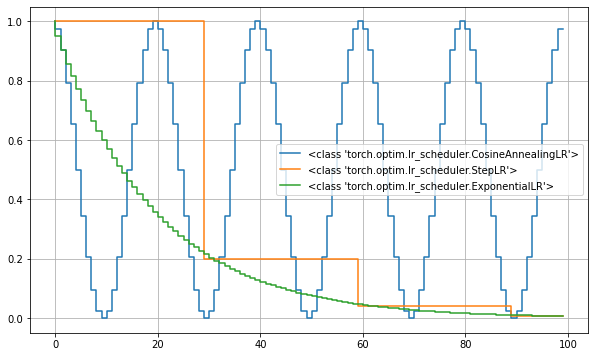

In [22]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ExponentialLR
model = Vit(
    in_channels=3,
    num_classes=2,
    num_patch_row=8,
    image_size=224,
    dropout=.1)
optimizer = Adam(model.parameters(), lr=1)

schedulers = [
    lambda optim: CosineAnnealingLR(optim, T_max=10), # 半周期 10 の cosine
    lambda optim: StepLR(optim, step_size=30, gamma=.2), # 30 epoch ごとに学習率を 0.05 倍
    lambda optim: ExponentialLR(optim, gamma=.95) # 毎 epoch ごとに 0.95 倍
]

epochs = list(range(100))
fig, ax = plt.subplots(figsize=(10, 6))

for get_scheduler in schedulers:
    rates = []
    sche = get_scheduler(Adam(model.parameters(), lr=1.))

    for i in epochs:
        rates.append(sche.get_last_lr()[0])
        sche.step()

    ax.step(epochs, rates, label=type(sche))

# ax.set_yscale('log')
ax.grid()
ax.legend();

In [23]:
def run_fold(
    model: nn.Module,
    train_loader: data.DataLoader,
    valid_loader: data.DataLoader,
    n_epochs=50) -> np.ndarray:

    optimizer = Adam(model.parameters(), lr=1e-2)
    scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-4)

    for epoch in range(1, n_epochs + 1):
        print(f'epoch: {epoch} lr: {scheduler.get_last_lr()[0]:.4f}')
        train_loss, train_acc = train(model, optimizer, train_loader)
        valid_loss, valid_acc = valid(model=model, valid_loader=valid_loader)
        scheduler.step()
        print(f'score: train_loss {train_loss:.3f} train_acc {train_acc:.3f} valid_loss {valid_loss:.3f} valid_acc {valid_acc:.3f}')

In [24]:
seed_torch(0)
vit = Vit(
    in_channels=3,
    num_classes=2,
    num_patch_row=8,
    image_size=224,
    dropout=.1)
vit = vit.to(DEVICE)

In [25]:
seed_torch()
run_fold(
    model=vit,
    train_loader=train_loader,
    valid_loader=val_loader,
    n_epochs=20)

epoch: 1 lr: 0.0100
score: train_loss 2.258 train_acc 0.484 valid_loss 0.861 valid_acc 0.470
epoch: 2 lr: 0.0091
score: train_loss 0.777 train_acc 0.536 valid_loss 0.694 valid_acc 0.522
epoch: 3 lr: 0.0066
score: train_loss 0.701 train_acc 0.531 valid_loss 0.680 valid_acc 0.539
epoch: 4 lr: 0.0035
score: train_loss 0.695 train_acc 0.531 valid_loss 0.681 valid_acc 0.568
epoch: 5 lr: 0.0010
score: train_loss 0.707 train_acc 0.531 valid_loss 0.687 valid_acc 0.535
epoch: 6 lr: 0.0001
score: train_loss 0.676 train_acc 0.573 valid_loss 0.679 valid_acc 0.548
epoch: 7 lr: 0.0010
score: train_loss 0.697 train_acc 0.521 valid_loss 0.675 valid_acc 0.583
epoch: 8 lr: 0.0035
score: train_loss 0.809 train_acc 0.547 valid_loss 0.966 valid_acc 0.470
epoch: 9 lr: 0.0066
score: train_loss 0.803 train_acc 0.536 valid_loss 0.816 valid_acc 0.470
epoch: 10 lr: 0.0091
score: train_loss 0.840 train_acc 0.516 valid_loss 0.679 valid_acc 0.602
epoch: 11 lr: 0.0100
score: train_loss 0.794 train_acc 0.516 valid_lo

学習はできるが、性能改善には DataAugmentation や事前学習済みモデルのファインチューニングが必要

---

## 事前学習済みモデルの活用

- PyTorch Image MOdels
- https://github.com/rwightman/pytorch-image-models

※ torchvisionmodels にもある

In [26]:
# !pip3 -q install timm

In [27]:
import timm

In [28]:
print('Available Vision Transformer Models: ')
timm.list_models('vit*')

Available Vision Transformer Models: 


['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_clip_laion2b',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_giant_patch14_224_clip_laion2b',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_clip_laion2b',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch14_224',
 'vit_large_

In [29]:
# ベースモデルの取得
MODEL_NAME = 'vit_base_patch16_224'
_model = timm.create_model(MODEL_NAME, pretrained=False)
print(_model.head)
for param in _model.parameters():
    param.requires_grad = False
# タスクに合わせてアーキテクチャを変更
_model.head = nn.Linear(_model.head.in_features, 2)
print(_model.head)

Linear(in_features=768, out_features=1000, bias=True)
Linear(in_features=768, out_features=2, bias=True)


In [30]:
# アーキテクチャと更新するパラメータの確認
# !pip3 -q install torchsummary
# from torchsummary import summary
# _model = _model.to(DEVICE)
# summary(_model, input_size=(3, 224, 224))

In [32]:
class ViTBased(nn.Module):
    def __init__(self, n_classes:int=2):

        super(ViTBased, self).__init__()

        self.model = timm.create_model(MODEL_NAME, pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        out = self.model(x)
        return out

In [33]:
seed_torch()
vit = ViTBased(n_classes=2)
vit = vit.to(DEVICE)

In [34]:
def run_fold(
    model: nn.Module,
    train_loader: data.DataLoader,
    valid_loader: data.DataLoader,
    n_epochs=50) -> np.ndarray:

    optimizer = Adam(model.parameters(), lr=1e-2)

    for epoch in range(1, n_epochs+1):
        print(f'epoch: {epoch}')
        train_loss, train_acc = train(model, optimizer, train_loader)
        valid_loss, valid_acc = valid(model=model, valid_loader=valid_loader)
        print(f'score: train_loss {train_loss:.3f} train_acc {train_acc:.3f} valid_loss {valid_loss:.3f} valid_acc {valid_acc:.3f}')

In [35]:
run_fold(
    model=vit,
    train_loader=train_loader,
    valid_loader=val_loader,
    n_epochs=3)

epoch: 1
score: train_loss 0.381 train_acc 0.891 valid_loss 0.072 valid_acc 0.974
epoch: 2
score: train_loss 0.037 train_acc 0.984 valid_loss 0.000 valid_acc 1.000
epoch: 3
score: train_loss 0.000 train_acc 1.000 valid_loss 0.000 valid_acc 1.000
